<a href="https://colab.research.google.com/github/di-wu-dw/teamA-grebes-NMA2020/blob/master/20200722_DW_PCA_GLM_RunningSpeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* dat['sresp']: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* dat['run']: timebins by 1, a.k.a. the running speed of the animal in a.u.
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['pupilArea']: timebins by 1, see FaceMap for details on the pupil tracker
* dat['pupilCOM']: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* dat['beh_svd_time']: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* dat['beh_svd_mask']: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]:  reconstruction of the face movie (its motion energy) for frame T

In [3]:
print(dat['sresp'].shape)
print(len(dat['stat']))
print((dat['stat'][19].dtype))
print(dat['stat'][19]['med'])

(11983, 7018)
11983
[('ipix', 'O'), ('ypix', 'O'), ('xpix', 'O'), ('lam', 'O'), ('lambda', 'O'), ('npix', 'O'), ('med', 'O'), ('neuropilCoefficient', 'O'), ('baseline', 'O'), ('footprint', 'O'), ('mrs', 'O'), ('mrs0', 'O'), ('cmpct', 'O'), ('aspect_ratio', 'O'), ('ellipse', 'O'), ('mimgProj', 'O'), ('mimgProjAbs', 'O'), ('isoverlap', 'O'), ('radius', 'O'), ('ipix_neuropil', 'O'), ('dFstat', 'O'), ('skew', 'O'), ('std', 'O'), ('maxMinusMed', 'O'), ('top5pcMinusMed', 'O'), ('blockstarts', 'O'), ('iplane', 'O'), ('iscell', 'O'), ('noiseLevel', 'O')]
[array([[191.5,  23. ]])]


In [4]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
#@title global variables
training_len = 5000 #cut-off index for training vs testing

N = len(dat['stat']) #total number of Neurons

# Ca2+ Signal

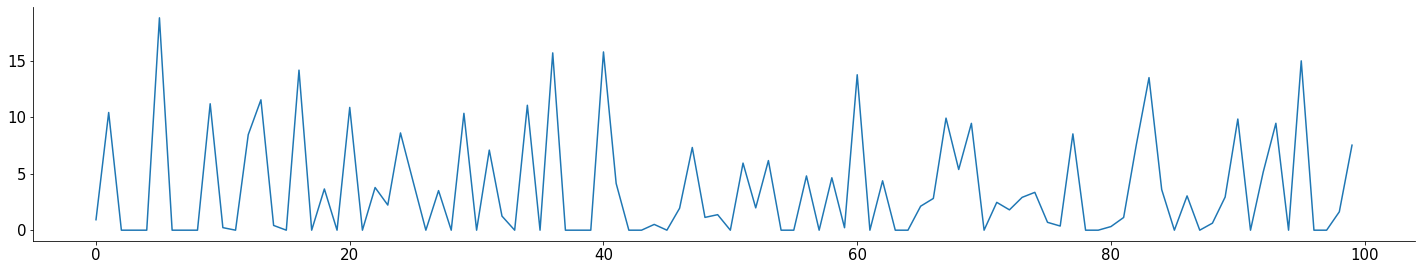

In [6]:
neuron_idx = 5
stop_len = 100
plt.plot(dat['sresp'][neuron_idx,:stop_len])

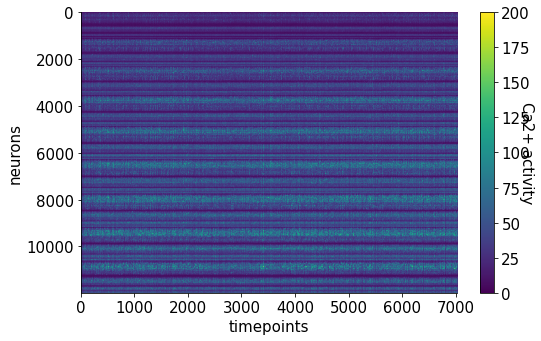

In [69]:
#@title plotting all the data
N = 11983 # number of neurons for plotting
stop_len = 7018 #cut-off index for plotting time-trace
saturation = 200 #saturate pixel with activity level above this

plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
plt.imshow(dat['sresp'][:N,:stop_len], vmax = saturation, aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Ca2+ activity', rotation=270)

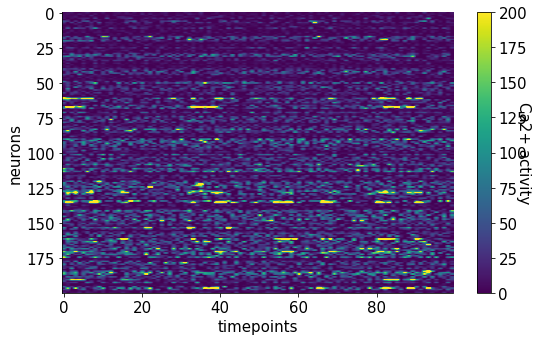

In [70]:
#@title plotting a sub-set
N = 200 # number of neurons for plotting
stop_len = 100 #cut-off index for plotting time-trace
saturation = 200 #saturate pixel with activity level above this

plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
plt.imshow(dat['sresp'][:N,:stop_len], vmax = saturation, aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Ca2+ activity', rotation=270)

# Running Speed

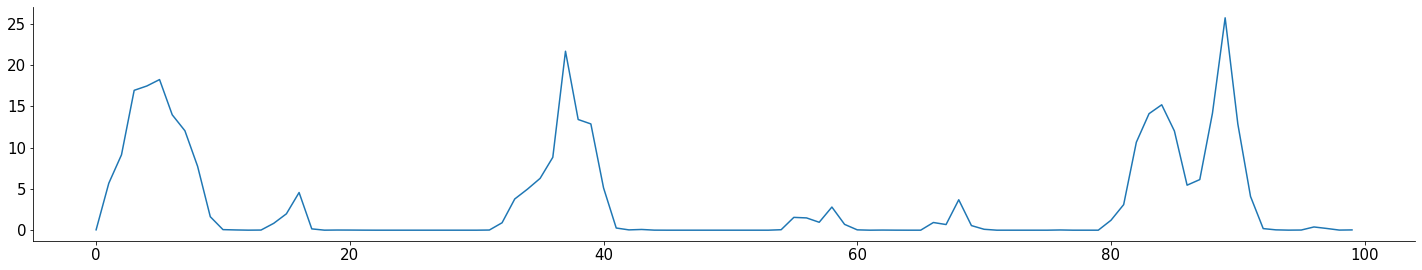

In [9]:
plt.plot(dat['run'][:stop_len])

# Separate Training and Testing Data

In [10]:
X = dat['sresp'][:,:training_len]
X = X.T

run_idx = [x[0] for x in dat['run']]
y = np.array(run_idx[:training_len])

# PCA to determine intrinsic dimensionality

In [11]:
from sklearn.decomposition import PCA
pca_model = PCA() # Initializes PCA
pca_model.fit(X) # Performs PCA 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [12]:
pca_model.components_
pca_model.explained_variance_

array([1.6705015e+06, 1.5129988e+06, 1.1980186e+06, ..., 3.0145541e+02,
       2.9827328e+02, 5.8006467e-06], dtype=float32)

In [13]:
def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()

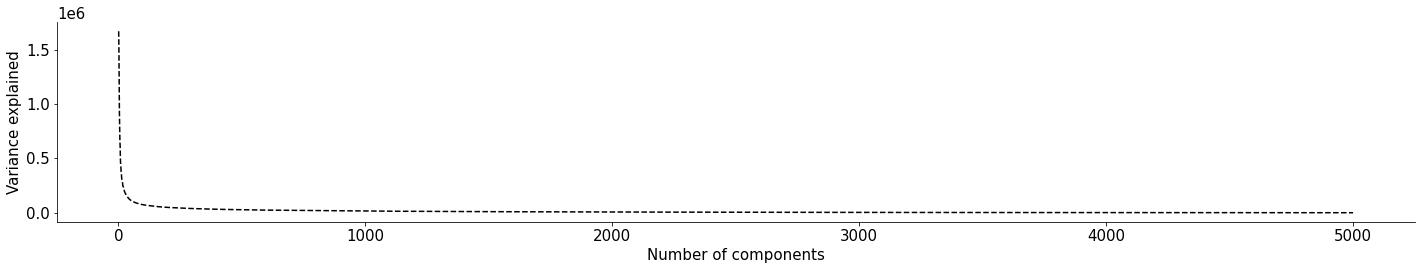

In [14]:
plot_variance_explained(pca_model.explained_variance_)

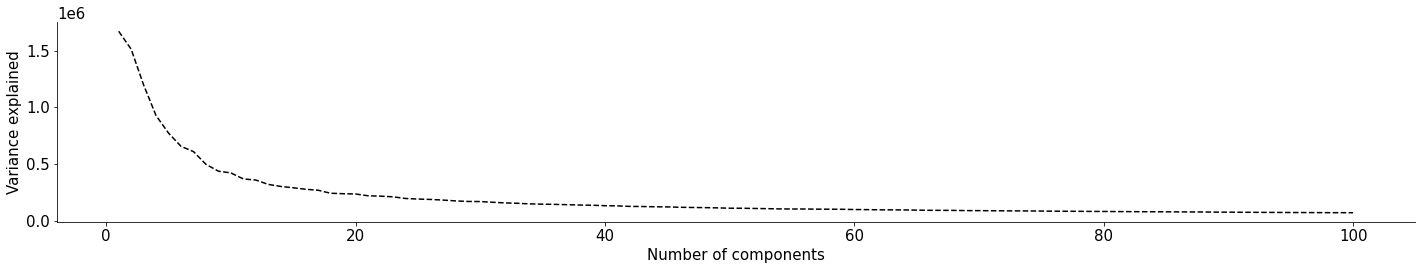

In [15]:
plot_variance_explained(pca_model.explained_variance_[:100])

## Transform input using first 100 PCs

In [16]:
X_pc = PCA(n_components=100).fit_transform(X)

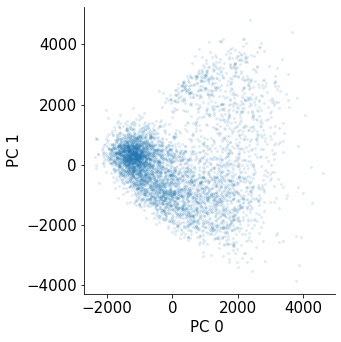

In [67]:
plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)
plt.scatter(X_pc[:,0], X_pc[:,1], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

# PCs as input features to linear regression

## Gaussian GLM

In [18]:
pca_model.components_[0,:]

array([ 2.5205733e-04, -2.2620364e-04, -1.2642547e-04, ...,
       -8.1303110e-04,  5.5209384e-04, -6.8032001e-05], dtype=float32)

In [71]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

In [51]:
Lin_reg = LinearRegression(fit_intercept="True",copy_X='True')
Lin_reg.fit(X_pc, y)

LinearRegression(copy_X='True', fit_intercept='True', n_jobs=None,
                 normalize=False)

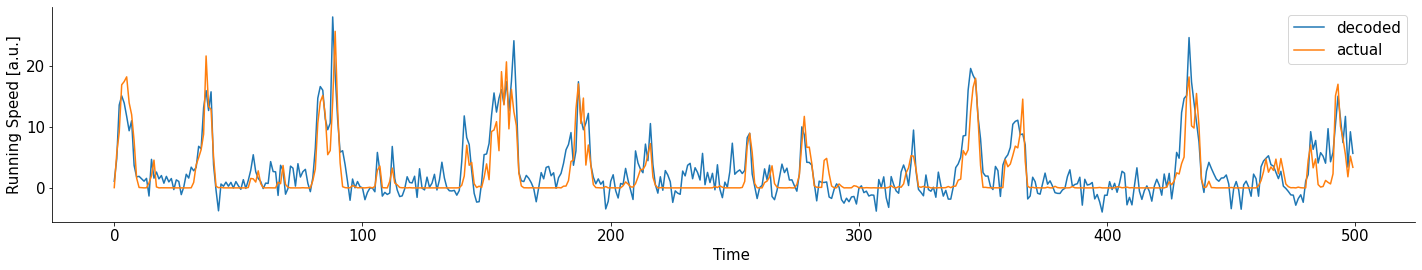

In [20]:
y_hat = Lin_reg.predict(X_pc)

stop_len = 500
ax = plt.subplot(1,1,1)
plt.plot(y_hat[:stop_len],label='decoded')
plt.plot(dat['run'][:stop_len],label='actual')
ax.set(xlabel = 'Time ', ylabel = 'Running Speed [a.u.]');
plt.legend()

## Cross Validation

In [82]:
RMSE = cross_val_score(Lin_reg, X_pc, y, cv=8, scoring = 'neg_root_mean_squared_error') # k=8 crossvalidation
print(-RMSE)

[3.50982885 3.16825293 5.66828485 3.37570836 2.27933336 3.21324737
 3.3361033  3.37984194]


What is happening when we get a negative r2 value?

In [49]:
#sorted(sklearn.metrics.SCORERS.keys())

## GLM with L1 loss (Lasso)

In [60]:
Lin_reg_l1 = Lasso(alpha = 1, fit_intercept=True, copy_X = True, max_iter= 1000)
Lin_reg_l1.fit(X_pc, y)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

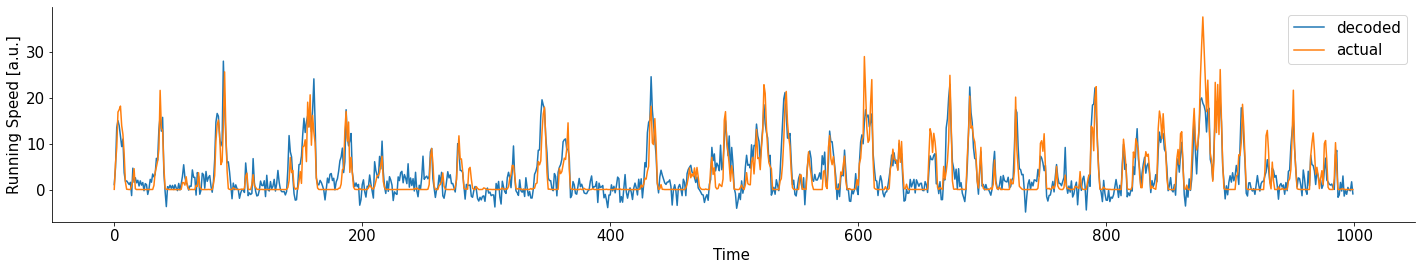

In [61]:
y_hat = Lin_reg_l1.predict(X_pc)

stop_len = 1000
ax = plt.subplot(1,1,1)
plt.plot(y_hat[:stop_len],label='decoded')
plt.plot(dat['run'][:stop_len],label='actual')
ax.set(xlabel = 'Time ', ylabel = 'Running Speed [a.u.]');
plt.legend()

In [81]:
RMSE = cross_val_score(Lin_reg_l1, X_pc, y, cv=8, scoring = 'neg_root_mean_squared_error') # k=8 crossvalidation
print(-RMSE)

[3.50193616 3.16607732 5.68926619 3.37621332 2.27497216 3.20915251
 3.33393149 3.37306862]


## Model Selection using Cross Validation

In [94]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  rmse = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = Lasso(alpha = C, fit_intercept=True, copy_X = True, max_iter= 1000)
    # Get the accuracy for each test split
    error = -1*cross_val_score(model, X, y, cv=8,scoring = 'neg_root_mean_squared_error')

    # Store the average test accuracy for this value of C
    rmse.append(error.mean())

  return rmse


def plot_model_selection(C_values, rmse):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, rmse, marker="o")
  best_C = C_values[np.argmin(rmse)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated Root-mean-squared-error",
      title=f"Best C: {best_C:1g} ({np.min(rmse):.2%})",
  )

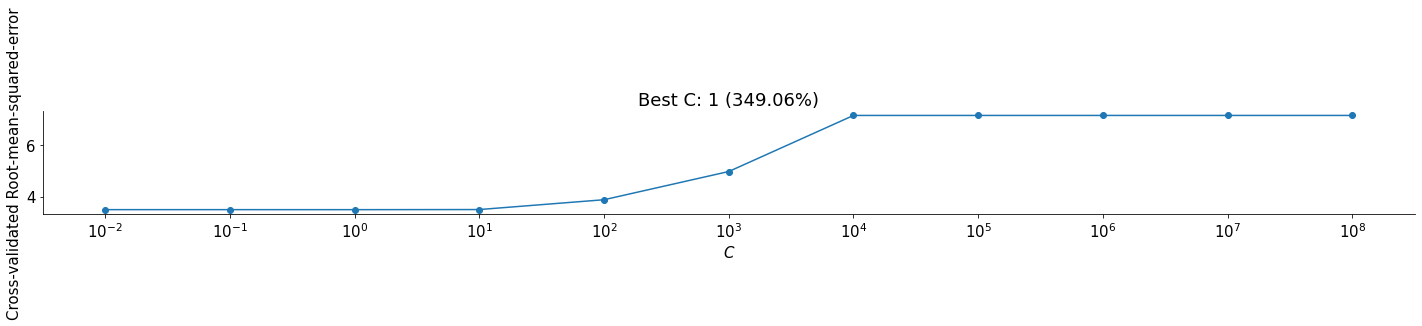

In [95]:
# Use log-spaced values for C
C_values = np.logspace(-2, 8, 11)

rmse = model_selection(X_pc, y, C_values)

plot_model_selection(C_values, rmse)

In [96]:
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="PC")
  f.tight_layout()

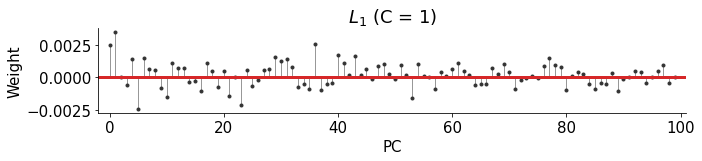

In [111]:
Lin_reg_l1 = Lasso(alpha = 1, fit_intercept=True, copy_X = True, max_iter= 1000)
Lin_reg_l1.fit(X_pc, y)

plot_weights({"$L_1$ (C = 1)": Lin_reg_l1})

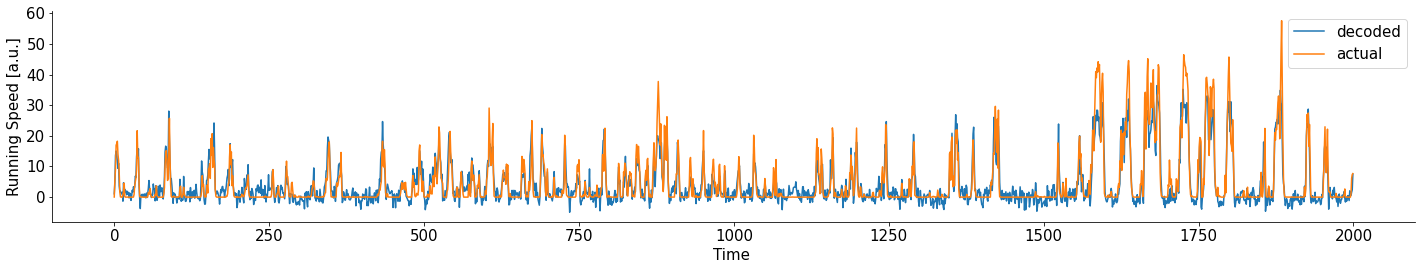

In [112]:
y_hat = Lin_reg_l1.predict(X_pc)

stop_len = 2000
ax = plt.subplot(1,1,1)
plt.plot(y_hat[:stop_len],label='decoded')
plt.plot(dat['run'][:stop_len],label='actual')
ax.set(xlabel = 'Time ', ylabel = 'Running Speed [a.u.]');
plt.legend()

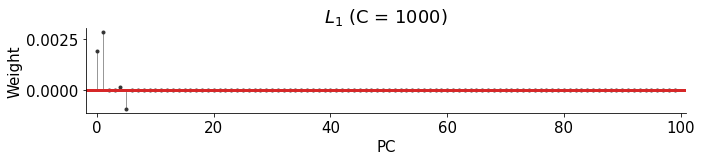

In [115]:
Lin_reg_l1 = Lasso(alpha = 1000, fit_intercept=True, copy_X = True, max_iter= 1000)
Lin_reg_l1.fit(X_pc, y)

plot_weights({"$L_1$ (C = 1000)": Lin_reg_l1})

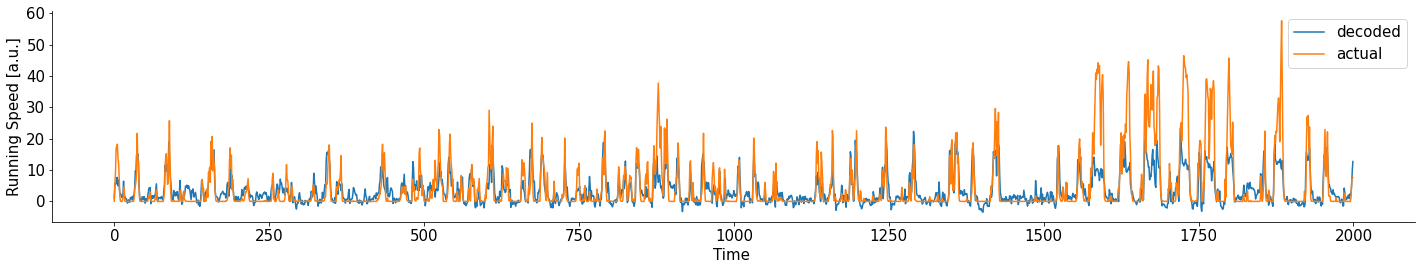

In [116]:
y_hat = Lin_reg_l1.predict(X_pc)

stop_len = 2000
ax = plt.subplot(1,1,1)
plt.plot(y_hat[:stop_len],label='decoded')
plt.plot(dat['run'][:stop_len],label='actual')
ax.set(xlabel = 'Time ', ylabel = 'Running Speed [a.u.]');
plt.legend()

# Next:

*   Visualize activity in PC space